In [1]:
import numpy as np
import pandas as pd
import re
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import STL
from IPython import display
from datetime import datetime
from collections import defaultdict
%matplotlib inline

# Methods

In [2]:
# ----------------------------------------------
# Check for nulls
# ----------------------------------------------
def check_nulls(features):
    print("\n\u001b[1mChecking Nulls:\u001b[0m")
    null_percentage = (features.isnull().sum() / features.shape[0]) * 100
    null_percentage = null_percentage[null_percentage > 0].reset_index()
    
    null_percentage.columns = ['Feature', 'Null_Percentage']
    
    if not null_percentage.empty:
        print(null_percentage.to_string(index=False))
    else:
        print("No features with null values.")

# Question 1

In [3]:
#Opening Listing File
listing = pd.read_csv('C:/Users/elena.zampieri.SUMUP/Desktop/Udacity - Project 1/archive/listings.csv')
listing.head()
listing_rows = listing.shape[0]
listing_col = listing.shape[1]
print('listing.csv contains',(listing_rows),'rows and',(listing_col),'columns')
check_nulls(listing)

listing.csv contains 3585 rows and 95 columns

Checking Nulls:
                     Feature  Null_Percentage
                     summary         3.988842
                       space        29.483961
       neighborhood_overview        39.470014
                       notes        55.090656
                     transit        35.983264
                      access        41.534170
                 interaction        43.347280
                 house_rules        33.249651
               thumbnail_url        16.708508
                  medium_url        16.708508
              xl_picture_url        16.708508
               host_location         0.306834
                  host_about        36.513250
          host_response_time        13.138075
          host_response_rate        13.138075
        host_acceptance_rate        13.138075
          host_neighbourhood         9.456067
               neighbourhood        15.146444
neighbourhood_group_cleansed       100.000000
                 

In [4]:
#Check for nulls in the price column
print('There are',listing['price'].isnull().sum(),'null values in the price column')

#Transform Variable Type
listing['host_since'] = pd.to_datetime(listing['host_since'])

#Transform Price Column
def extract_price_number(price_string):
    return float(re.sub(r"[^\d.]", "", price_string))
listing['price'] = listing['price'].apply(extract_price_number)

#Create X matrix with the features and Y matrix with value we want to predict
listing_y = listing['price']
listing_x = listing[['id','host_is_superhost','host_since','neighbourhood_cleansed','bathrooms']]

#Count nulls in features 
print('Each column has the following amount of nulls:','\n',listing_x[['id','host_is_superhost','host_since','neighbourhood_cleansed','bathrooms']].isnull().sum())

#Fill Numeric Nulls with Mean
listing_num_vars = listing_x.select_dtypes(include=['float', 'int']).columns

for col in listing_num_vars:
    listing_x[col].fillna((listing_x[col].mean()), inplace=True)
        
#Dummy Variables
listing_cat_vars = listing_x.select_dtypes(include=['object']).copy().columns
print(listing_cat_vars)

for var in  listing_cat_vars:
    # for each cat add dummy var, drop original column
    listing_x = pd.concat([listing_x.drop(var, axis=1), pd.get_dummies(listing_x[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

#Date into numeric Variable
today = datetime.now()
listing_x['days_as_host'] = (today - listing_x['host_since']).dt.days
listing_x = listing_x.drop('host_since', axis=1)
 
#Renaming Columns
listing_x = listing_x.rename(columns={'host_is_superhost_t': 'host_is_superhost', 
                                      'neighbourhood_cleansed_Back Bay': 'back_bay_neighbourhood',
                                      'neighbourhood_cleansed_Bay Village': 'bay_village_neighbourhood',
                                      'neighbourhood_cleansed_Beacon Hill': 'beacon_hill_neighbourhood',
                                      'neighbourhood_cleansed_Brighton': 'brighton_neighbourhood',
                                      'neighbourhood_cleansed_Charlestown': 'charlestown_neighbourhood',
                                      'neighbourhood_cleansed_Chinatown': 'chinatown_neighbourhood',
                                      'neighbourhood_cleansed_Dorchester': 'dorchester_neighbourhood',
                                      'neighbourhood_cleansed_Mission Hill': 'mission_hill_neighbourhood',
                                      'neighbourhood_cleansed_North End': 'north_end_neighbourhood',
                                      'neighbourhood_cleansed_Roslindale': 'roslindale_neighbourhood',
                                      'neighbourhood_cleansed_Roxbury': 'roxbury_neighbourhood',
                                      'neighbourhood_cleansed_South Boston': 'south_boston_neighbourhood',
                                      'neighbourhood_cleansed_South Boston Waterfront': 'south_boston_waterfront_neighbourhood',
                                      'neighbourhood_cleansed_South End': 'south_end_neighbourhood',
                                      'neighbourhood_cleansed_West End': 'west_end_neighbourhood',
                                      'neighbourhood_cleansed_West Roxbury': 'west_roxbury_neighbourhood'})
listing_x.head()



There are 0 null values in the price column
Each column has the following amount of nulls: 
 id                         0
host_is_superhost          0
host_since                 0
neighbourhood_cleansed     0
bathrooms                 14
dtype: int64
Index(['host_is_superhost', 'neighbourhood_cleansed'], dtype='object')


C:\Users\elena.zampieri.SUMUP\AppData\Local\Temp\ipykernel_25048\2586214668.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listing_x[col].fillna((listing_x[col].mean()), inplace=True)


,id,bathrooms,host_is_superhost,back_bay_neighbourhood,bay_village_neighbourhood,beacon_hill_neighbourhood,brighton_neighbourhood,charlestown_neighbourhood,chinatown_neighbourhood,dorchester_neighbourhood,...,mission_hill_neighbourhood,north_end_neighbourhood,roslindale_neighbourhood,roxbury_neighbourhood,south_boston_neighbourhood,south_boston_waterfront_neighbourhood,south_end_neighbourhood,west_end_neighbourhood,west_roxbury_neighbourhood,days_as_host
0,12147973,1.5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2996
1,3075044,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4038
2,6976,1.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5161
3,1436513,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3720
4,7651065,1.5,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3335


In [5]:
#def clean_fit_linear_mod(df_feature,df_response, test_size=.3, rand_state=42):
# Split into test and train variable
listing_x_train, listing_x_test, listing_y_train, listing_y_test = train_test_split(listing_x, listing_y, test_size=.3, random_state=133)

# Instantiate
lm_model = LinearRegression() 

# Fit
lm_model.fit(listing_x_train, listing_y_train) 

#Predict using your model
listing_y_test_preds = lm_model.predict(listing_x_test)
listing_y_train_preds = lm_model.predict(listing_x_train)

#Score using your model
listing_test_score = r2_score(listing_y_test, listing_y_test_preds)
listing_train_score = r2_score(listing_y_train, listing_y_train_preds)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(listing_train_score, listing_test_score))
    
#return listing_test_score, listing_train_score, lm_model, listing_x_train, listing_x_test, listing_y_train, listing_y_test

#Test your function with the above dataset
#listing_test_score, listing_train_score, lm_model, listing_x_train, listing_x_test, listing_y_train, listing_y_test = clean_fit_linear_mod(listing_x,listing_y)

The rsquared on the training data was 0.22755911569027287.  The rsquared on the test data was 0.17014848434066265.


In [6]:
# Get coeficients by feature
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, listing_x_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
23,south_boston_waterfront_neighbourhood,177.373911,177.373911
3,back_bay_neighbourhood,131.270319,131.270319
4,bay_village_neighbourhood,130.020569,130.020569
10,neighbourhood_cleansed_Downtown,123.211208,123.211208
5,beacon_hill_neighbourhood,120.771400,120.771400
8,chinatown_neighbourhood,119.424471,119.424471
15,neighbourhood_cleansed_Leather District,99.703772,99.703772
12,neighbourhood_cleansed_Fenway,91.721573,91.721573
19,north_end_neighbourhood,88.675707,88.675707
24,south_end_neighbourhood,88.032948,88.032948


# Question 2

In [7]:
#Calendar File
calendar = pd.read_csv('C:/Users/elena.zampieri.SUMUP/Desktop/Udacity - Project 1/archive/calendar.csv')

#Decribe
calendar_rows = calendar.shape[0]
min_date = calendar['date'].min()
max_date = calendar['date'].max()
price_nan = calendar['price'].isnull().sum()/calendar.shape[0]
print('calendar.csv contains',(calendar_rows),'rows' )
print('The first date is',min_date, 'and the last date is',max_date)
print("{:.2%}".format(price_nan), 'of price values are null')
print("There are ",calendar['listing_id'].nunique(),"unique listings and 365 days")
price_not_null = calendar[calendar['price'].notnull()]
print (price_not_null.groupby('available')['listing_id'].nunique())
print (calendar.groupby('available')['listing_id'].nunique())

calendar.csv contains 1308890 rows
The first date is 2016-09-06 and the last date is 2017-09-05
50.87% of price values are null
There are  3585 unique listings and 365 days
available
t    2906
Name: listing_id, dtype: int64
available
f    3482
t    2906
Name: listing_id, dtype: int64


In [8]:
#Prepare the dataframe
calendar_clean = calendar.dropna(subset=['price'])
calendar_clean.head()
calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
calendar_clean['price'] = calendar_clean['price'].apply(extract_price_number)
calendar_clean.info()
print(calendar_clean['date'].max())
print(calendar_clean['date'].min())

C:\Users\elena.zampieri.SUMUP\AppData\Local\Temp\ipykernel_25048\3873715144.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  643037 non-null  int64         
 1   date        643037 non-null  datetime64[ns]
 2   available   643037 non-null  object        
 3   price       643037 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 24.5+ MB
2017-09-05 00:00:00
2016-09-06 00:00:00


C:\Users\elena.zampieri.SUMUP\AppData\Local\Temp\ipykernel_25048\3873715144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['price'] = calendar_clean['price'].apply(extract_price_number)


# Price per month

In [9]:
# Grouping by month
calendar_clean['month'] = calendar_clean['date'].dt.to_period('M')
calendar_clean_grouped = calendar_clean.groupby(['month',]).agg({'price': ['mean', 'median']})
calendar_clean_grouped.reset_index(drop=False, inplace=True)
calendar_clean_grouped.head()

C:\Users\elena.zampieri.SUMUP\AppData\Local\Temp\ipykernel_25048\1573686645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['month'] = calendar_clean['date'].dt.to_period('M')


month       price       
                  mean median
0  2016-09  252.677308  209.0
1  2016-10  233.416248  185.0
2  2016-11  202.924416  160.0
3  2016-12  192.601915  155.0
4  2017-01  182.799671  150.0

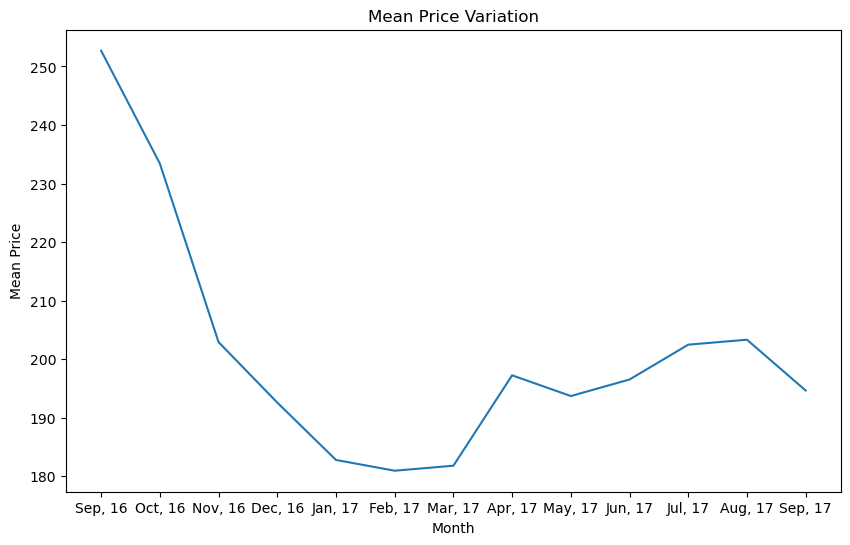

In [10]:
# Convert 'month' column to string format
calendar_clean_grouped['month'] = calendar_clean_grouped['month'].dt.strftime('%b, %y')

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot the mean price variation
plt.plot(calendar_clean_grouped['month'], calendar_clean_grouped[('price', 'mean')])

# Set the chart title and labels
plt.title('Mean Price Variation')
plt.xlabel('Month')
plt.ylabel('Mean Price')


# Show the plot
plt.show()

# Price per month per neighbourhood

In [11]:
# Merging with listing df to get neighborhood information
merged_calendar_listing = pd.merge(calendar_clean[['listing_id', 'date', 'available','price']],
                        listing[['id','neighbourhood_cleansed']],
                        left_on='listing_id',
                        right_on='id',
                        how='left')
merged_calendar_listing = merged_calendar_listing[['listing_id', 'date', 'available','price','neighbourhood_cleansed']]
merged_calendar_listing.head()

# Grouping by month
merged_calendar_listing['month'] = merged_calendar_listing['date'].dt.to_period('M')
merged_calendar_listing_grouped = merged_calendar_listing.groupby(['month', 'neighbourhood_cleansed']).agg({'price': ['mean', 'median']})
merged_calendar_listing_grouped.head()

price       
                                      mean median
month   neighbourhood_cleansed                   
2016-09 Allston                 162.894163  113.0
        Back Bay                350.367374  349.0
        Bay Village             282.542553  249.0
        Beacon Hill             252.813582  225.0
        Brighton                149.200345  100.0

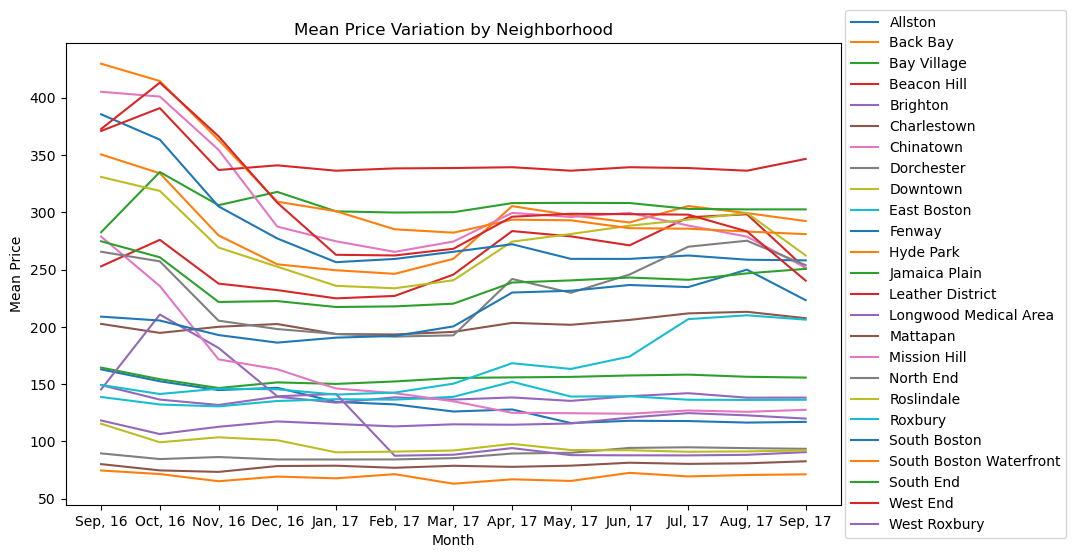

In [12]:
# Reset the index of the grouped DataFrame
merged_calendar_listing_grouped.reset_index(drop=False, inplace=True)

# Convert 'month' column to string format
merged_calendar_listing_grouped['month'] = merged_calendar_listing_grouped['month'].dt.strftime('%b, %y')

# Create a line plot
plt.figure(figsize=(10, 6))

# Iterate over each neighborhood
for neighborhood, data in merged_calendar_listing_grouped.groupby('neighbourhood_cleansed'):
    # Plot the mean price variation
    plt.plot(data['month'], data['price']['mean'], label=neighborhood)

# Set the chart title and labels
plt.title('Mean Price Variation by Neighborhood')
plt.xlabel('Month')
plt.ylabel('Mean Price')

# Add a legend
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))

# Show the plot
plt.show()


In [13]:
# Merging with listing df to get neighborhood information
merged_calendar_listing = pd.merge(calendar_clean[['listing_id', 'date', 'available','price']],
                        listing[['id','neighbourhood_cleansed']],
                        left_on='listing_id',
                        right_on='id',
                        how='left')
merged_calendar_listing = merged_calendar_listing[['listing_id', 'date', 'available','price','neighbourhood_cleansed']]
merged_calendar_listing.head()

# Grouping the median price
merged_calendar_listing_grouped = merged_calendar_listing.groupby(['date', 'neighbourhood_cleansed'])['price'].median().reset_index()
merged_calendar_listing_grouped.head()

,date,neighbourhood_cleansed,price
0,2016-09-06,Allston,108.0
1,2016-09-06,Back Bay,239.0
2,2016-09-06,Bay Village,167.0
3,2016-09-06,Beacon Hill,193.5
4,2016-09-06,Brighton,99.0


# Trying SLT Model

In [ ]:
# Define a function to apply STL decomposition to each group
def apply_stl(group):
    # Fit the STL model
    stl = STL(group['price'], period=365)
    result = stl.fit()
    
    # Extract the seasonal, trend, and residual components
    group['seasonal'] = result.seasonal
    group['trend'] = result.trend
    group['residual'] = result.resid
    
    return group

# Apply STL decomposition to each group in the grouped DataFrame
stl_result = merged_calendar_listing_grouped.groupby('neighbourhood_cleansed').apply(apply_stl)


In [ ]:
# Group the stl_result DataFrame by neighborhood
grouped_by_neighborhood = stl_result.groupby('neighbourhood_cleansed')

# Iterate over each neighborhood and plot the components
for neighborhood, group in grouped_by_neighborhood:
    # Create subplots for seasonal, trend, and residual
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    
    # Plot seasonal component
    axes[0].plot(group['date'], group['seasonal'])
    axes[0].set_title(f"Seasonal Component - {neighborhood}")
    
    # Plot trend component
    axes[1].plot(group['date'], group['trend'])
    axes[1].set_title(f"Trend Component - {neighborhood}")
    
    # Plot residual component
    axes[2].plot(group['date'], group['residual'])
    axes[2].set_title(f"Residual Component - {neighborhood}")
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [ ]:
merged_calendar_listing['date'] = pd.to_datetime(merged_calendar_listing['date'])
merged_calendar_listing.info()
monthly_merged_calendar_listing = merged_calendar_listing.groupby('listing_id')['price'].mean().reset_index()
merged_calendar_listing.head()

In [ ]:
monthly_merged_calendar_listing = merged_calendar_listing.groupby('listing_id')['price'].resample('M', on='date').mean().reset_index()
monthly_merged_calendar_listing.head()

# Question 3

In [4]:
#Question 3
def total_count(df, col1, col2, look_for):
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

possible_vals = ["TV", '"Cable TV"','"Wireless Internet"','"Air Conditioning"',"Kitchen","Heating","Washer","Dryer", 
                 "Internet","Gym",'"Elevator in Building"','"Buzzer/Wireless Intercom"',"Heating",'"Family/Kid Friendly"',
                 '"Smoke Detector"','"Carbon Monoxide Detector"',"Essentials","Shampoo",'"24-Hour Check-in"',"Hangers",'"Hair Dryer"',
                 "Iron",'"Laptop Friendly Workspace"','"Fire Extinguisher"','"Wheelchair Accessible"','"Pets Allowed"',"Doorman",
                 '"Indoor Fireplace"','"Suitable for Events"']

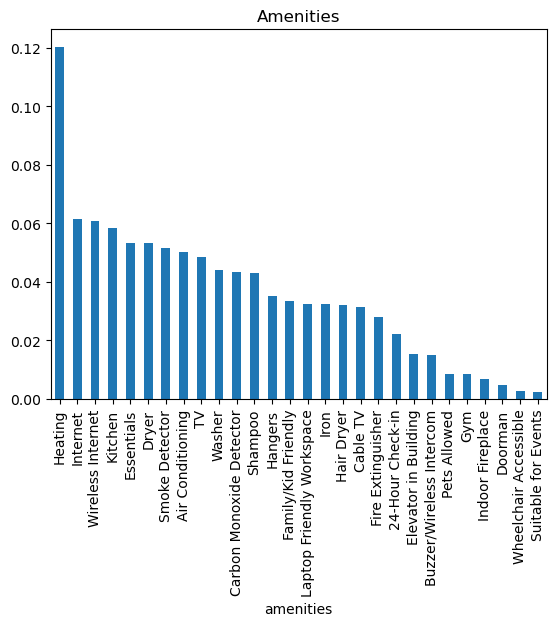

In [26]:
def clean_and_plot(df, title='Amenities', plot=True):
    amenities = listing['amenities'].value_counts().reset_index()
    amenities.rename(columns={'index': 'amenities', 'amenities': 'count'}, inplace=True)
    amenities_df = total_count(amenities, 'amenities', 'count', possible_vals)
    amenities_df['amenities'] = amenities_df['amenities'].apply(lambda x: x.strip('"'))
    amenities_df.set_index('amenities', inplace=True)
    if plot:
        (amenities_df/amenities_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_amenities_df = amenities_df/amenities_df.sum()
    return props_amenities_df
    
props_df = clean_and_plot(listing)